In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix


Load dataset

In [2]:
# fetch the training file
file_path_20_percent = './input/KDDTrain+_20Percent.txt'
file_path_full_training_set = './input/KDDTrain+.txt'
file_path_test = './input/KDDTest+.txt' 

#df = pd.read_csv(file_path_20_percent)
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)

In [3]:
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'value_idx_failed_logins', 'logged_in', 'value_idx_compromised', 'root_shell', 'su_attempted', 'value_idx_root', 'value_idx_file_creations', 'value_idx_shells', 'value_idx_access_files', 'value_idx_outbound_cmds', 'is_host_login', 'is_guest_login', 'idx', 'srv_idx', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_idx', 'dst_host_srv_idx', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level']
df.columns = columns
test_df.columns = columns
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


Data transformation: Add binary valued label column `attack_flag` based on `attack` column values(normal: 0, others: 1)

In [4]:
# map normal to 0, all attacks to 1
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)
df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1


Data Transformation: Classifying each `attack` with a value for better prediction model

In [5]:
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
U2R = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
Sybil = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

attack_chart_labels = ['Normal','DoS','Probe','U2R','Sybil']

def map_attack(attack):
    if attack in dos_attacks:
        attack_type = 1  # Corrected from `attack = 1` to `attack_type = 1`
    elif attack in probe_attacks:
        attack_type = 2
    elif attack in U2R:
        attack_type = 3
    elif attack in Sybil:
        attack_type = 4
    else:
        attack_type = 0
    return attack_type

# map the data and join to the data set
attack_map = df.attack.apply(map_attack)
df['attack_map'] = attack_map

test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1,1


**Visual Representation of Dataset**
 see how things are distributed.

In [6]:
def bake_pies(dataset_list, chart_labels):
    dataset_idx = len(dataset_list)
    
    palette_list = sns.color_palette()
    palette_cycle = itertools.cycle(palette_list)
    color_map = {}
    
    figure, subplots = plt.subplots(1, dataset_idx, figsize=(18, 10), tight_layout=False)
    plt.subplots_adjust(wspace=1/dataset_idx)
    
    for idx, single_dataset in enumerate(dataset_list):
        for value_idx, value in enumerate(np.unique(single_dataset.index)):
            if value not in color_map:
                color_map[value] = next(palette_cycle)
        pie_wedges, pie_texts = subplots[idx].pie(single_dataset,
                                       colors=[color_map[v] for v in single_dataset.index])
        subplots[idx].legend(pie_wedges, single_dataset.index,
                          title="Flags",
                          loc="center left",
                          bbox_to_anchor=(1, 0, 0.5, 1))
        subplots[idx].set_title(chart_labels[idx])
    return subplots

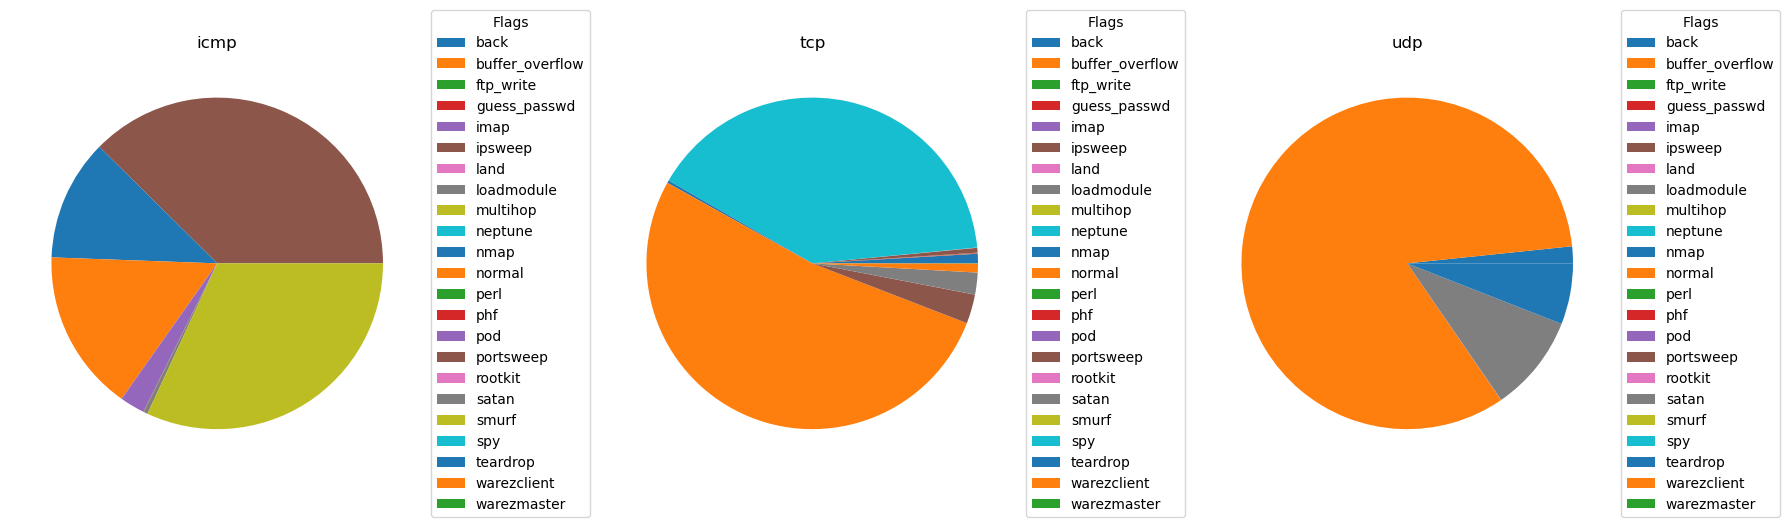

In [7]:
attack_vs_protocol = pd.crosstab(df.attack, df.protocol_type)

# get the series for each protocol
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp

# create the charts
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
plt.show()

Our monitoring strategy uses a series continuous network protocols and capable of learning subtle distinction between threats and legal ones. Historical information fed the machine learning model classify Sybil and other attacks (ddos, probe, u2r). It helps to identify recurring patterns of Sybil, DDoS, U2R, Probe attacks and locate in long-term traffic chain.

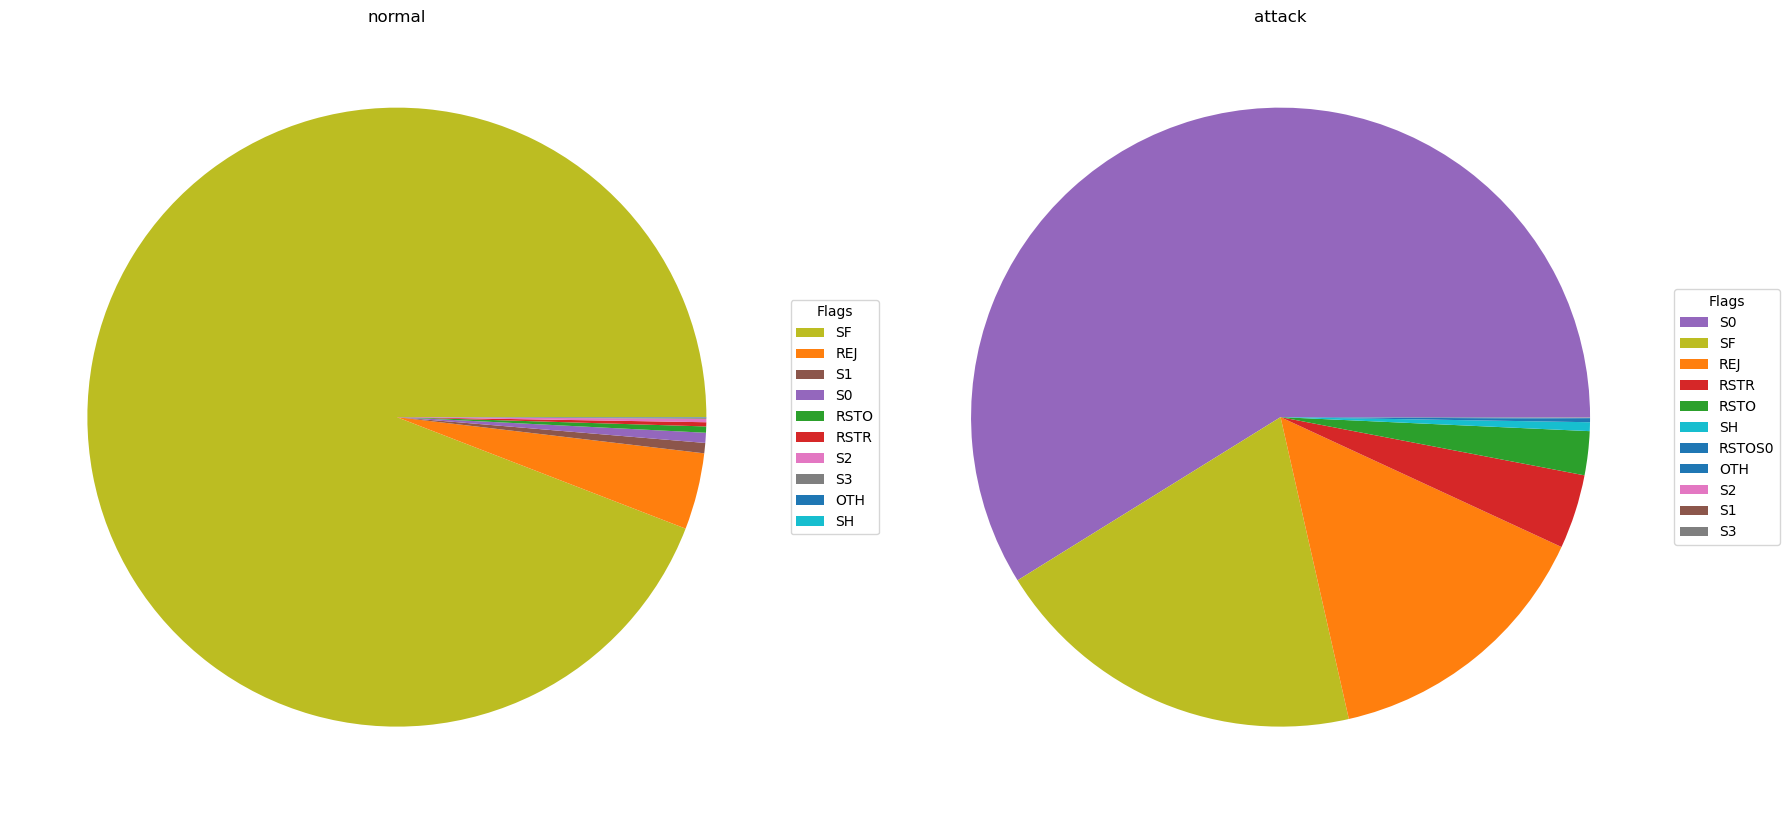

In [8]:
# get a series with the idx of each flag for attack and normal traffic
normal_flags = df.loc[df.attack_flag == 0].flag.value_counts()
attack_flags = df.loc[df.attack_flag == 1].flag.value_counts()

# create the charts
flag_subplots = bake_pies([normal_flags, attack_flags], ['normal','attack'])        
plt.show()

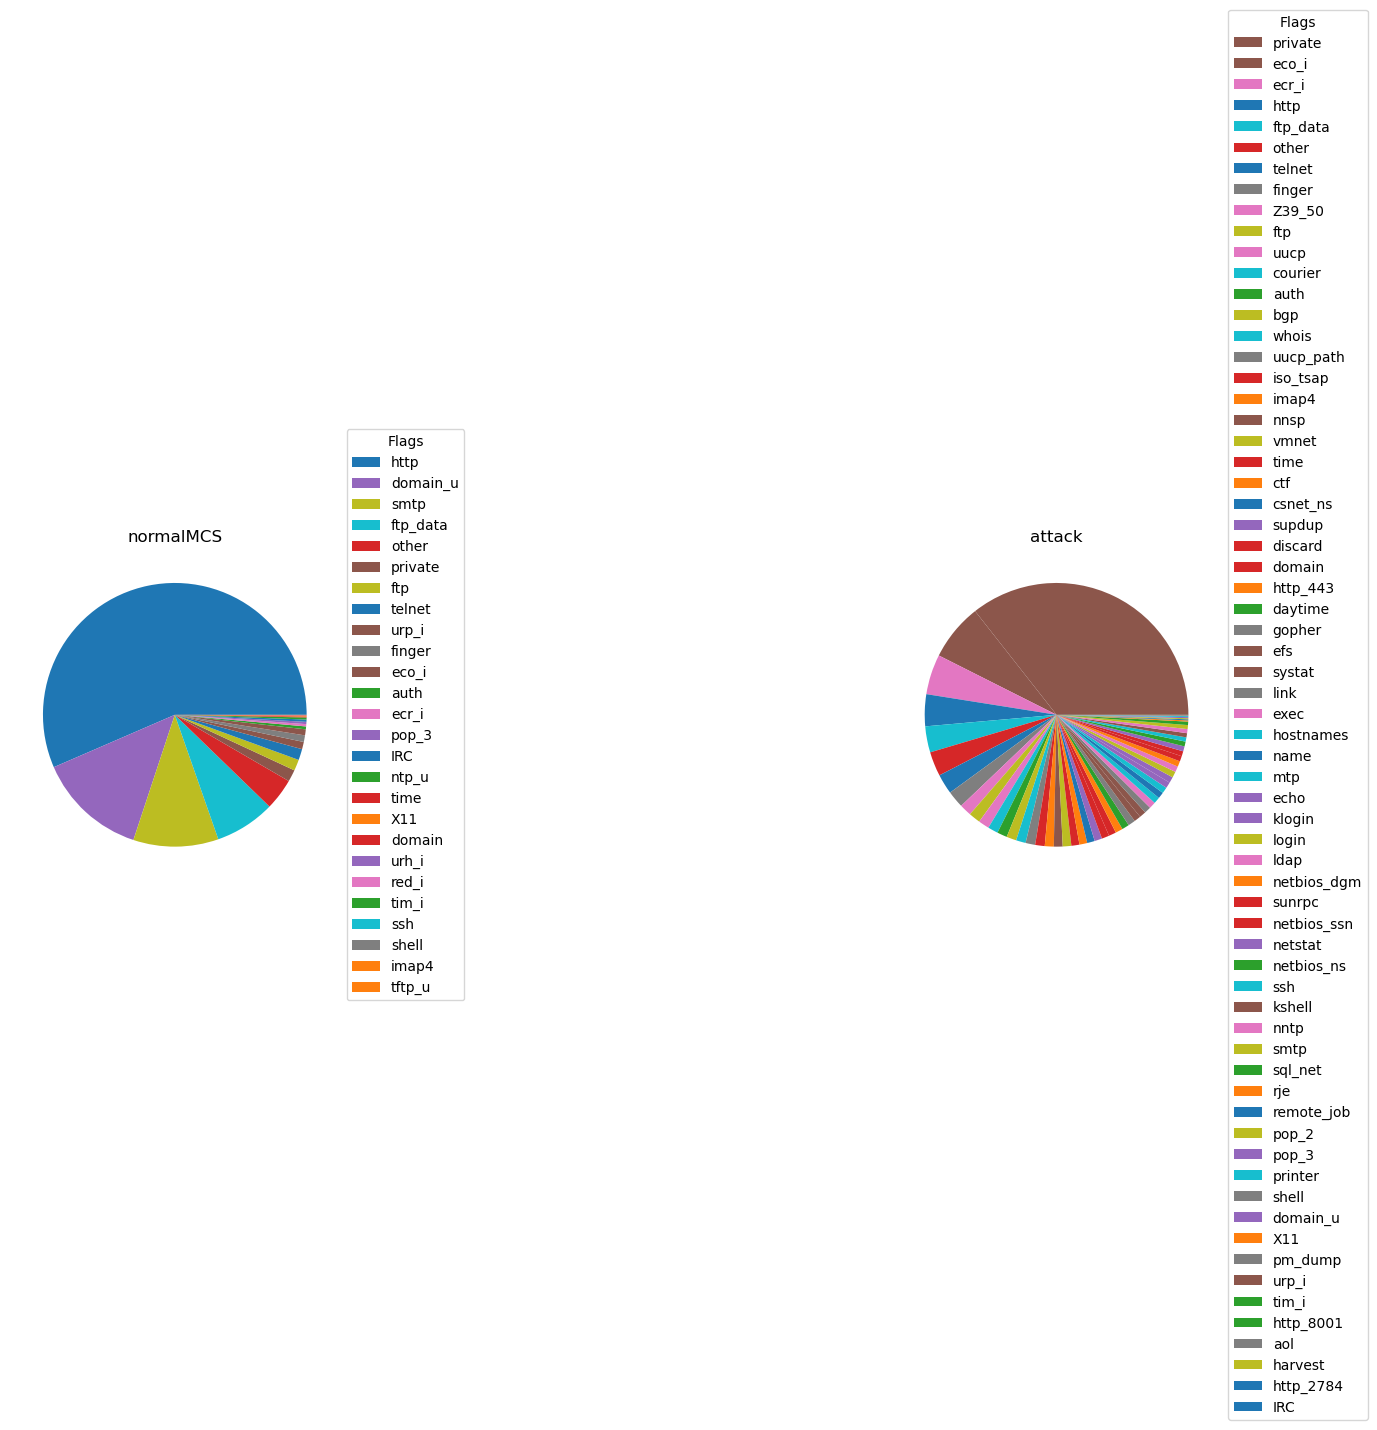

In [9]:
# get a series with the idx of each service for attack and normal MCS
normal_services = df.loc[df.attack_flag == 0].service.value_counts()
attack_services = df.loc[df.attack_flag == 1].service.value_counts()

# create the charts
service_subplots = bake_pies([normal_services, attack_services], ['normalMCS','attack'])        
plt.show()


Our data show that huge normal traffic is http, our attack traffic is all over the MCS. Sybil attacks are searching for many different paths into MCS systems; some well traveled and some not.



**Feature engineering**


In [10]:
# get the intial set of encoded features and encode them
features_to_encode = ['protocol_type', 'service', 'flag']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])

# not all of the features are in the test set, so we need to account for diffs
test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))

diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

# we'll also need to reorder the columns to match, so let's get those
column_order = encoded.columns.to_list()

# append the new columns
test_encoded_temp = test_encoded_base.join(diff_df)

# reorder the columns
test_final = test_encoded_temp[column_order].fillna(0)

# get numeric features, we won't worry about encoding these at this point
value_features = ['duration', 'src_bytes', 'dst_bytes']

# model to fit/test
to_fit = encoded.join(df[value_features])
test_set = test_final.join(test_df[value_features])

Divide the data into testing and training sets to start: binrary and multi classifications.

In [11]:
# create our target classifications
binary_y = df['attack_flag']
multi_y = df['attack_map']

test_binary_y = test_df['attack_flag']
test_multi_y = test_df['attack_map']

# build the training sets
binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.4)
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(to_fit, multi_y, test_size = 0.4)

**Model fitting**
Based on the nature of the data, decision trees are a good starting point for building out predictive models. In this case we'll use a random forest to build and combine multiple trees. 

In [12]:
# model for the binary classification
binary_model = RandomForestClassifier()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)

# calculate and display our base accuracty
base_rf_score = accuracy_score(binary_predictions,binary_val_y)
base_rf_score

0.9935501796026911

Comapre with different model using cross_val_score.

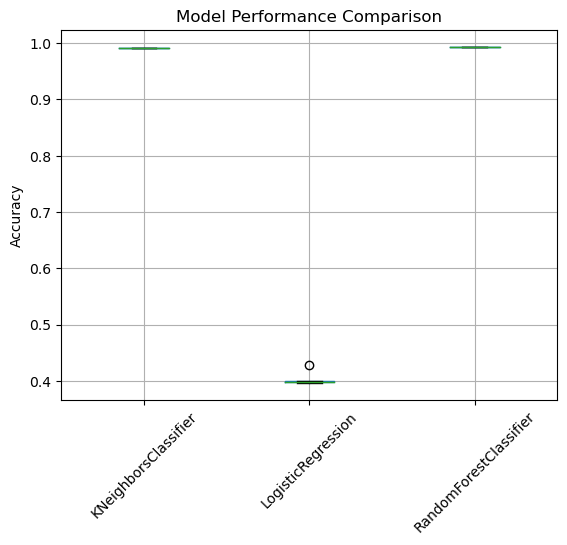

In [13]:
# Convert to NumPy array if needed
binary_train_X = binary_train_X.values
binary_train_y = binary_train_y.values

# Define the list of models to test
models = [
    RandomForestClassifier(random_state=42),
    LogisticRegression(max_iter=250, random_state=42),
    KNeighborsClassifier(n_neighbors=5, metric='euclidean'),
]

# Capture the performance of each model
model_comps = []

# Iterate through models and compute cross-validation scores
for model in models:
    model_name = model.__class__.__name__
    try:
        accuracies = cross_val_score(model, binary_train_X, binary_train_y, scoring='accuracy', cv=5)
        for idx, accuracy in enumerate(accuracies):
            model_comps.append((model_name, idx, accuracy))
    except Exception as e:
        print(f"Error with model {model_name}: {e}")

# Create a DataFrame for results
result_df = pd.DataFrame(model_comps, columns=['Model', 'Fold', 'Accuracy'])

# Plot the results
result_df.pivot(index='Fold', columns='Model', values='Accuracy').boxplot(rot=45)
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.show()


 random forest and K-nearest perform well but logistic give loww accuracy

**Confusion Matrix**
Now, Summarizing the performance of a classification algorithm. 

In [14]:
# a helper function for getting some analytical data about our predictions
def add_predictions(single_dataset,predictions,y):
    prediction_series = pd.Series(predictions, index=y.index)

    # we need to add the predicted and actual outcomes to the data
    predicted_vs_actual = single_dataset.assign(predicted=prediction_series)
    original_data = predicted_vs_actual.assign(actual=y).dropna()
    conf_matrix = confusion_matrix(original_data['actual'], 
                                   original_data['predicted'])
    
    # capture rows with failed predictions
    base_errors = original_data[original_data['actual'] != original_data['predicted']]
    
    # drop columns with no value
    non_zeros = base_errors.loc[:,(base_errors != 0).any(axis=0)]

    # idetify the type of error
    false_positives = non_zeros.loc[non_zeros.actual==0]
    false_negatives = non_zeros.loc[non_zeros.actual==1]

    # put everything into an object
    prediction_data = {'data': original_data,
                       'confusion_matrix': conf_matrix,
                       'errors': base_errors,
                       'non_zeros': non_zeros,
                       'false_positives': false_positives,
                       'false_negatives': false_negatives}
    
    return prediction_data


<Axes: >

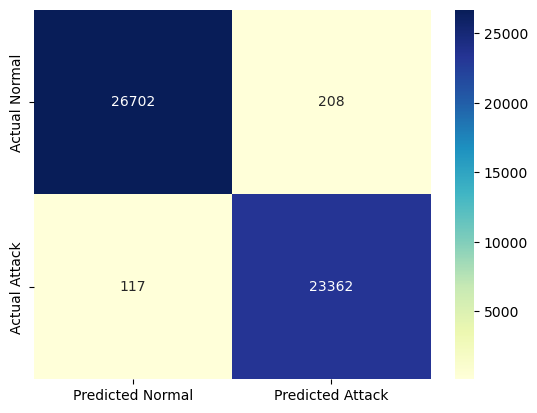

In [15]:
# capture our prediction data
binary_prediction_data = add_predictions(df,
                                         binary_predictions,
                                         binary_val_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=binary_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)%

In [16]:
# Pre-processing and Exploratory Data Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standard scaling for numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[value_features])
scaled_df = pd.DataFrame(scaled_features, columns=value_features)

def plot_distribution(df, features, target_variable=None):
    for feature in features:
        plt.figure(figsize=(8, 5))
        sns.histplot(data=df, x=feature, hue=target_variable, kde=True, bins=30)
        plt.title(f"Distribution of {feature}")
        plt.show()

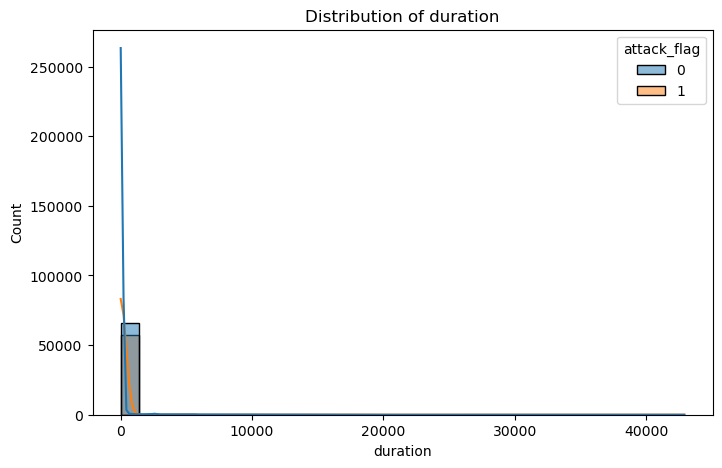

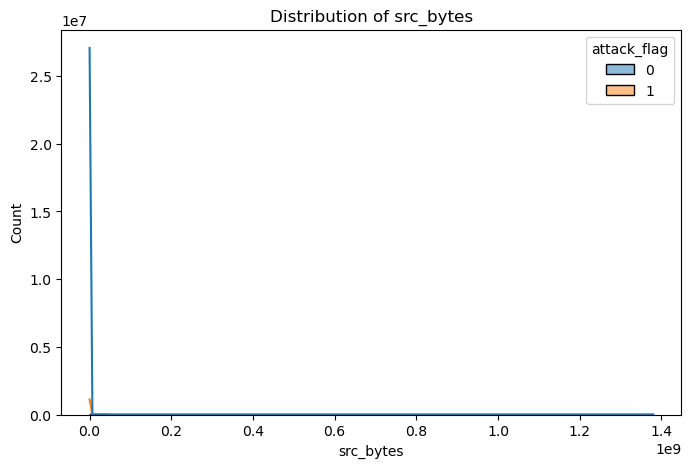

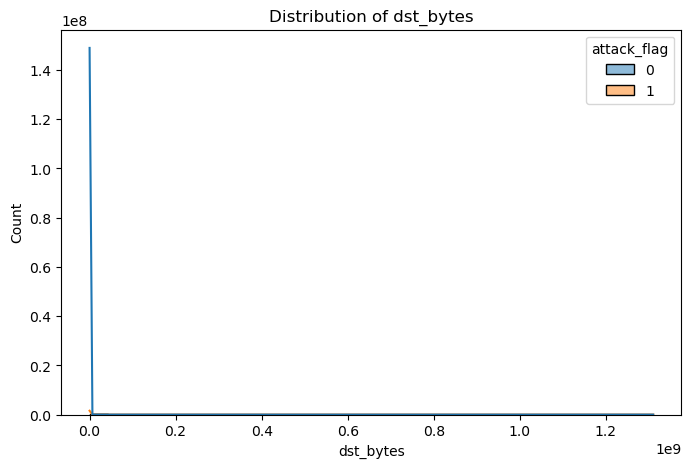

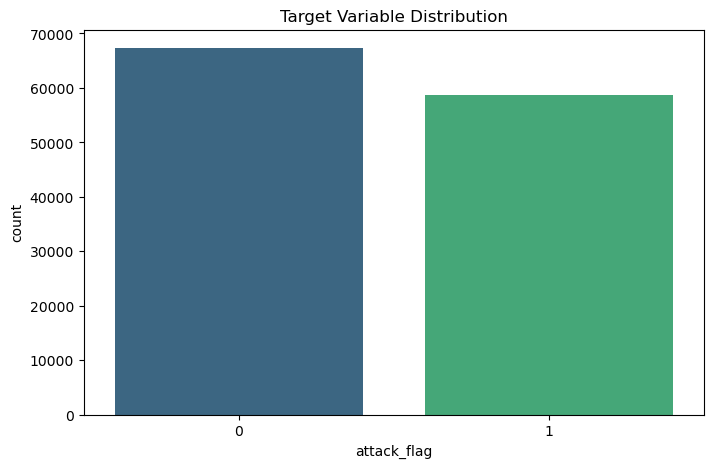

In [17]:
# Plot distributions for value features
plot_distribution(df, value_features, target_variable='attack_flag')

# Target variable distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df['attack_flag'], palette='viridis')
plt.title("Target Variable Distribution")
plt.show()

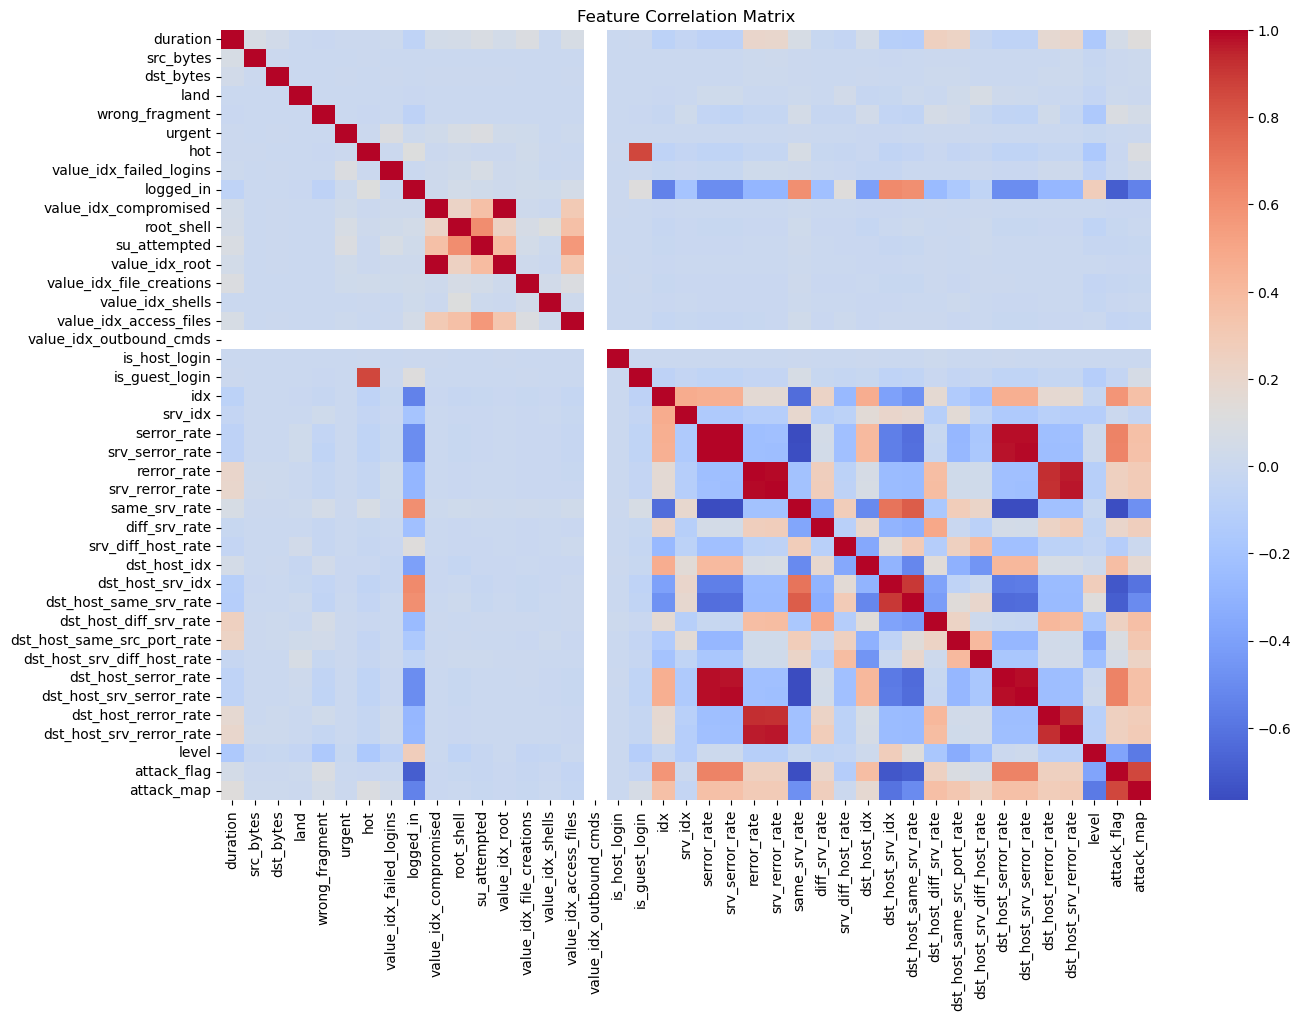

In [18]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()


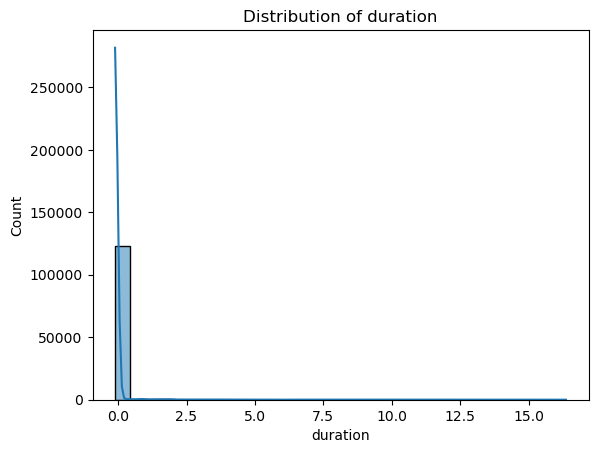

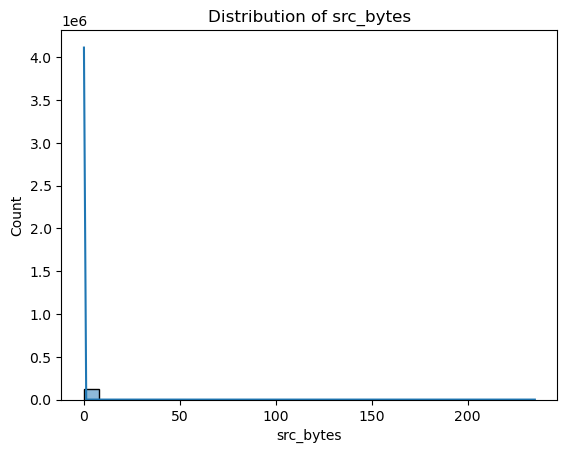

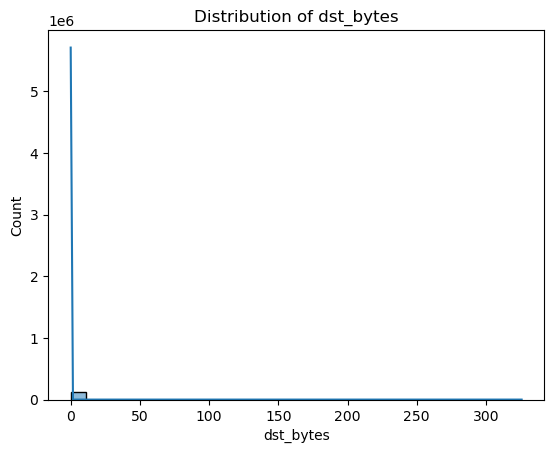

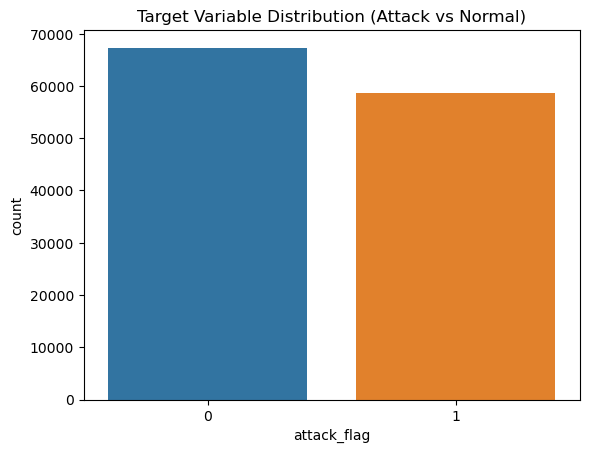

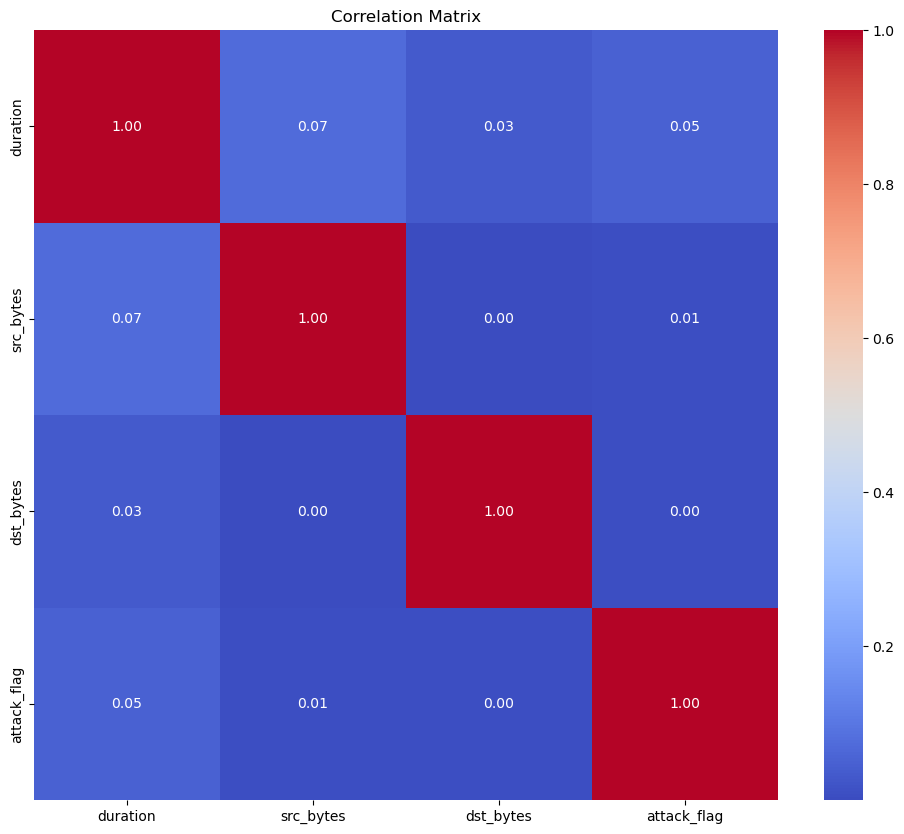

In [21]:
# Additional Plots and Analysis for the Mini-Project

# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Standard scaling of relevant features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[value_features])
df[value_features] = scaled_features
test_scaled_features = scaler.transform(test_df[value_features])
test_df[value_features] = test_scaled_features

# Exploratory Data Analysis
# Distribution plots of numerical features
for feature in value_features:
    plt.figure()
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.show()

# Target variable distribution
plt.figure()
sns.countplot(x=df['attack_flag'])
plt.title("Target Variable Distribution (Attack vs Normal)")
plt.show()

# Correlation matrix of features
plt.figure(figsize=(12, 10))
corr_matrix = df[value_features + ['attack_flag']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

